### Univariate profile with varying number of features

In [1]:
# make nice
# make comments

from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from palettable.matplotlib import Inferno_20 as ColMap
from fmri_decoder.data import SurfaceData
from src.data import Data
from src.config import SUBJECTS, SESSION, N_LAYER
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

# set
SESS = "GE_EPI"
NMAX = 500
GAUSSIAN = 2.0  # size of gaussian filter

In [2]:
class Univariate:
    """Compute the univariate profile for different number of features."""

    def __init__(self, subj, sess, day):
        self.subj = subj
        self.sess = sess
        self.day = day
        self.data = Data(self.subj, f"{self.sess}{SESSION[self.subj][self.sess][self.day]}")
        self.label, self.hemi = self.get_label
        self.label_sorted, self.hemi_sorted = zip(*[self.select_features(i) for i in range(N_LAYER)])

    @property
    @functools.lru_cache()
    def get_label(self):
        # get label and hemisphere
        surf_data = SurfaceData(self.data.file_layer, None, self.data.file_label)

        label_left = surf_data.load_label_intersection("lh")
        label_right = surf_data.load_label_intersection("rh")

        hemi = np.zeros(len(label_left)+len(label_right))
        hemi[len(label_left):] = 1
        label = np.append(label_left, label_right)

        return label, hemi

    def select_features(self, layer):
        dtf = pd.read_parquet(self.data.get_sample_data(layer))

        # choose subset of features
        features = dtf.columns[2:]
        
        X = np.array(dtf.loc[:, features])
        y = np.array(dtf.loc[:, "label"])

        f_statistic = f_classif(X, y)[0]
        index = np.arange(len(features))
        index_sorted = np.array(
                    [x for _, x in sorted(zip(f_statistic, index), reverse=True)]
                )

        label_sorted= self.label[index_sorted]
        hemi_sorted = self.hemi[index_sorted]

        return label_sorted, hemi_sorted

    def get_profile(self, nmax):
        # get data profiles
        y = np.zeros(N_LAYER)
        for i in range(N_LAYER):
            label = self.label_sorted[i][:nmax]
            hemi = self.hemi_sorted[i][:nmax]

            # load psc
            arr_left = self.data.get_psc("lh", i)
            arr_right = self.data.get_psc("rh", i)

            tmp = np.concatenate((arr_left[label[hemi==0]], 
                                  arr_right[label[hemi==1]]), axis=0)
            y[i] = np.mean(tmp)
        return y
    
    def n_features(self, n):
        y = np.zeros((n, N_LAYER))
        for i in range(n):
            y[i, :] = self.get_profile(i+1)
        if self.sess == "VASO":
            y *= -1
        return y

In [3]:
counter = 0
data = np.zeros((NMAX, N_LAYER))
for subj in SUBJECTS:
    for day in [0, 1]:
        data += Univariate(subj, SESS, day).n_features(NMAX)
        counter += 1
data /= counter

In [4]:
nx, ny = 500, 250
x, y = np.meshgrid(np.arange(ny), np.arange(nx))
data_resized = resize(data, (nx,ny))
data_filtered = gaussian_filter(data_resized, GAUSSIAN)

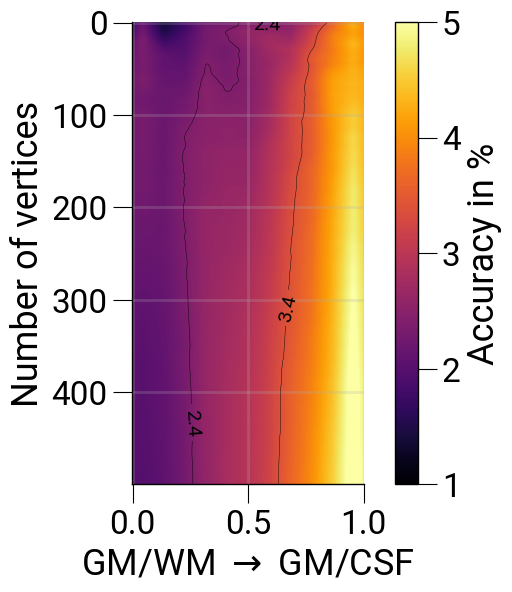

In [14]:
if SESS == "VASO":
    contour_range = [2.0, 3.0]
    clim_range = [0, 1]
elif SESS == "GE_EPI":
    contour_range = [2.4, 3.4]
    clim_range = [1, 5]
elif SESS == "SE_EPI":
    contour_range = [72.0, 75.0]
    clim_range = [0, 1]

fig, ax = plt.subplots()
im = ax.imshow(data_filtered, cmap=ColMap.mpl_colormap)
cs = ax.contour(x, y, data_filtered, contour_range, colors="black", linewidths=0.3)
im.set_clim(clim_range)
ax.clabel(cs, inline=True, fontsize=14)
ax.set_xticks([0, 125, 250], [0.0, 0.5, 1.0])
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Number of vertices")
cbar = plt.colorbar(im)
cbar.set_label("Accuracy in %")
file_out = f"/data/pt_01880/n_features_univariate_{SESS}.svg"
#fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")